Hi Kagglers!! We are here again with another amazing competition! 

In this notebook, let us try and explore the data given for **Prostate cANcer graDe Assessment (PANDA) Challenge**. Before we dive deep into the data, let us know a little more about the competition.

**I hope you find this notebook useful and your <font color="red"><b>UPVOTES</b></font> would be very much appreciated. It helps me keep Motivated :)**

# Prostate cANcer graDe Assessment (PANDA) Challenge
**Prostate cancer diagnosis using the Gleason grading system**

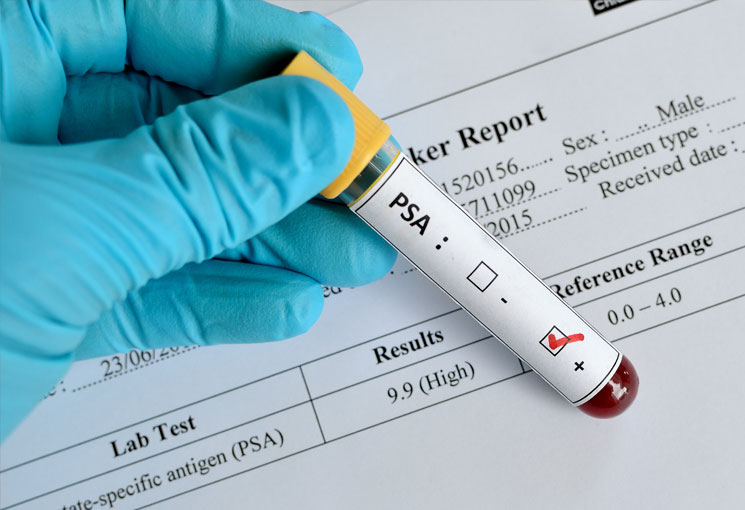

With more than 1 million new diagnoses reported every year, prostate cancer (PCa) is the second most common cancer among males worldwide that results in more than 350,000 deaths annually. The key to decreasing mortality is developing more precise diagnostics. Diagnosis of PCa is based on the grading of prostate tissue biopsies. These tissue samples are examined by a pathologist and scored according to the Gleason grading system.

The grading process consists of finding and classifying cancer tissue into so-called Gleason patterns (3, 4, or 5) based on the architectural growth patterns of the tumor (Fig. 1). After the biopsy is assigned a Gleason score, it is converted into an ISUP grade on a 1-5 scale.

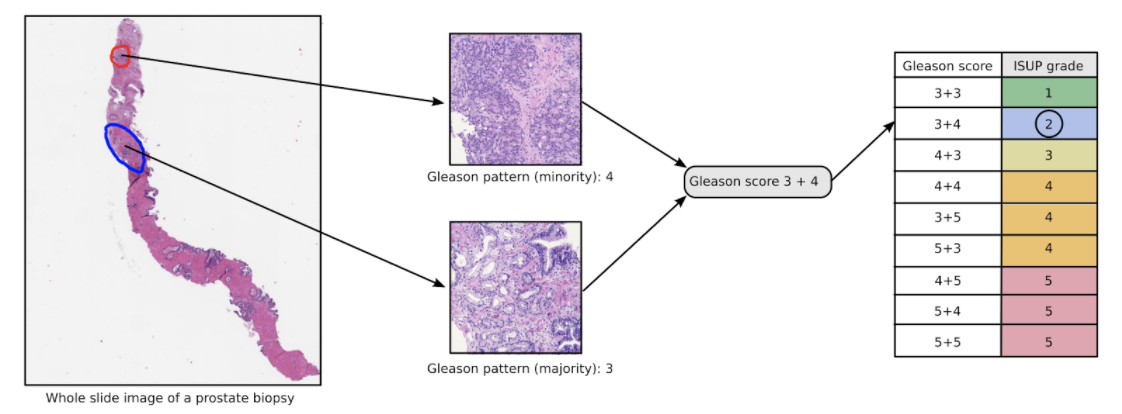

# Contents
1. [Understanding Data Files](#p1)
2. [Loading Required Packages](#p2)
3. [Load Data](#p3)
4. [Check for Missing Values](#p4)
5. [Exploratory Data Analysis](#p5)
6. [Images of Microscopy Scans of Prostate Biopsy Samples](#p6)
7. [Visualise the Label Masks](#p7)
8. [Overlaying Masks on the Slides](#p8)
9. [Analysis on the Imgae Characterstics](#p9)
10. [Conclusion](#p10)
11. [References](#p11)

# Understanding Data Files

Let's look at the data files given and understand what data they have and what they represent.

**[train/test].csv**

* **image_id:** ID code for the image.

* **data_provider**: The name of the institution that provided the data. Both the Karolinska Institute and Radboud University Medical Center contributed data. They used different scanners with slightly different maximum microscope resolutions and worked with different pathologists for labeling their images.

* **isup_grade:** Train only. The target variable. The severity of the cancer on a 0-5 scale.

* **gleason_score:** Train only. An alternate cancer severity rating system with more levels than the ISUP scale. For details on how the gleason and ISUP systems compare, see the Additional Resources tab.

**[train/test]_images: ** The images. Each is a large multi-level tiff file. You can expect roughly 1,000 images in the hidden test set. Note that slightly different procedures were in place for the images used in the test set than the training set. Some of the training set images have stray pen marks on them, but the test set slides are free of pen marks.

* **train_label_masks**: Segmentation masks showing which parts of the image led to the ISUP grade. Not all training images have label masks, and there may be false positives or false negatives in the label masks for a variety of reasons. These masks are provided to assist with the development of strategies for selecting the most useful subsamples of the images. The mask values depend on the data provider:

* **Radboud:** Prostate glands are individually labelled. Valid values are:

    0: background (non tissue) or unknown
    1: stroma (connective tissue, non-epithelium tissue)
    2: healthy (benign) epithelium
    3: cancerous epithelium (Gleason 3)
    4: cancerous epithelium (Gleason 4)
    5: cancerous epithelium (Gleason 5)

* **Karolinska:** Regions are labelled. Valid values are:

    1: background (non tissue) or unknown
    2: benign tissue (stroma and epithelium combined)
    3: cancerous tissue (stroma and epithelium combined)

* **sample_submission.csv**: A valid submission file. This is a notebooks-only competition; the downloadable test.csv and sample_submission.csv have been truncated. The full versions will be available to your submitted notebooks.

# Load Required Packages

In [ ]:
import pandas as pd 
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from matplotlib.patches import Rectangle
import seaborn as sns
import openslide
import PIL
%matplotlib inline 
PATH = "/kaggle/input/prostate-cancer-grade-assessment/"

# Load all the Data Files

In [ ]:
sample_submission_df = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))
train_df = pd.read_csv(os.path.join(PATH,'train.csv'))
test_df = pd.read_csv(os.path.join(PATH,'test.csv'))

In [ ]:
print(f"sample submission shape: {sample_submission_df.shape}")
print(f"train shape: {train_df.shape}")
print(f"test shape: {test_df.shape}")

#### Let's look at the Columns of each dataframes

In [ ]:
sample_submission_df.head()

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [ ]:
train_image_list = os.listdir(os.path.join(PATH, 'train_images'))
train_label_masks_list = os.listdir(os.path.join(PATH, 'train_label_masks'))

Test and Sample Submission .csv files have only 3 rows (samples).

The column **(gleason_score)** is only present in train data, that is not present either in test (with image_id & data_provider) or in sample submission (image_id & isup_grade) csv.

The goal is to predict **isup_grade** for each image in test set.

Let's check now the train data in train_images and train_label masks folders.

In [ ]:
print(f"train image_id list: {train_df.image_id.nunique()}")
print(f"train image list: {len(train_image_list)}")
print(f"train label masks list: {len(train_label_masks_list)}")

In [ ]:
print(f"sample of image_id list: {train_df.image_id.values[0:3]}")
print(f"sample of image list: {train_image_list[0:3]}")
print(f"sample of label masks list: {train_label_masks_list[0:3]}")

# Check for Missing Data

Let's check for the missing values in the data. For this, we will remove the suffix and extension from label masks and will remove the extension from image list.

In [ ]:
trimmed_image_list = []
for img in train_image_list:
    trimmed_image_list.append(img.split('.tiff')[0])

In [ ]:
trimmed_label_masks_list = []
for img in train_label_masks_list:
    trimmed_label_masks_list.append(img.split('_mask.tiff')[0])

Now, we will compare the intersections of sets of resulted lists.

In [ ]:
intersect_i_m = (set(trimmed_image_list) & set(trimmed_label_masks_list))
intersect_id_m = (set(train_df.image_id.unique()) & set(trimmed_label_masks_list))
print(f"image (tiff) & label masks: {len(intersect_i_m)}")
print(f"image_id (train) & label masks: {len(intersect_id_m)}")

The cardnality of both the intersections is equal with the data dimmensions. That means there is **No Missing Data!!!**:

All images indexed in train data has corresponding tiff images and tiff label masks.

# Exploratory Data Analysis

### BokehJS

BokehJS is the in-browser client-side runtime library that users of Bokeh ultimately interact with. This library is written primarily in TypeScript and is one of the unique things about the Bokeh plotting system.



We can use Matplotlib, Seaborn, Plotly etc. to generate great visualisations but let's also give BokehJS a try!!

**Install BokehJS with Pip, if you don't have it!**

In [ ]:
!pip install bokeh

In [ ]:
from bokeh.plotting import ColumnDataSource, figure, output_notebook, show
from bokeh.palettes import Spectral8
output_notebook()

Let's start with checking the distribution of **data_provider**,**isup_grade** and **gleason_score** in the training data (train_df).

We are gonna see the count of the data providers!

In [ ]:
provider = train_df['data_provider'].unique().tolist()
count_provider = train_df['data_provider'].value_counts().tolist()

tools = "hover,pan,wheel_zoom,box_zoom,reset,lasso_select"
source = ColumnDataSource(data=dict(provider=provider, counts=count_provider, color=Spectral8))
p = figure(x_range=provider, y_range=(0,6000), plot_width =900, plot_height = 400, title="Data Provider - Data Count",
           toolbar_location="right", tools = tools)
p.xaxis.axis_label = "Data Provider"
p.yaxis.axis_label = "Value Count"

# Render and show the vbar plot
p.vbar(x='provider', top='counts', width=0.3, color='color', source=source)
show(p)



[**Radboud University Medical Center**](http://www.radboudumc.nl/en/research) and [**Karolinska Institute** ](http://ki.se/en/meb)are the two data providers as well as the organisers of the competition.


In 2012, the [International Society of Urologic Pathologists (ISUP)](http://isupweb.org/isup/) proposed a novel, validated grading system for clear cell renal cell carcinoma (ccRCC) and papillary renal cell carcinoma (pRCC) that has been implemented by the World Health Organization (WHO).This system is based primarily on the nucleoli assessment of the tumors, as follows [1]:

* Grade 1: Inconspicuous nucleoli at ×400 magnification and basophilic
* Grade 2: Clearly visible nucleoli at ×400 magnification and eosinophilic
* Grade 3: Clearly visible nucleoli at ×100 magnification
* Grade 4: Extreme pleomorphism or rhabdoid and/or sarcomatoid morphology


Let's do a little analysis on the **ISUP grade**

In [ ]:
isup_grade = train_df['isup_grade'].unique().tolist()
count_isup_grade = train_df['isup_grade'].value_counts().tolist()

source2 = ColumnDataSource(data=dict(isup_grade=isup_grade, counts=count_isup_grade, color=Spectral8))
p2 = figure(y_range=(0,6000), plot_width =900, plot_height = 400, title="ISUP grade - Data Count",
           toolbar_location="right", tools = tools)

p2.xaxis.axis_label = "isup_grade"
p2.yaxis.axis_label = "Value Count"
p2.vbar(x='isup_grade', top='counts', width=0.3, color='color', source=source2)
show(p2)

The above graph illustrates that majority of data samples in training set have ISUP grade values 0 or 1 (total > 50%) and the rest of the data samples have associated ISUP grades from 2 to 5 with all ranging in the 11-12% each.

#### Let's Do a lite Analysis on the Gleason_Score

In [ ]:
gleason_score = train_df['gleason_score'].unique().tolist()
count_gleason_score= train_df['gleason_score'].value_counts().tolist()

source_3 = ColumnDataSource(data=dict(gleason_score = gleason_score, counts = count_gleason_score, color=Spectral8))
p3 = figure(x_range = gleason_score,y_range=(0,4000), plot_width =900, plot_height = 400, title="Gleason score - Data Count",
           toolbar_location="right", tools = tools)

p3.xaxis.axis_label = "isup_grade"
p3.yaxis.axis_label = "Value Count"
p3.vbar(x='gleason_score', top='counts', width=0.4, color='color', source = source_3)
show(p3)

The above plot clearly illustrates that the data is imbalanced with respect of **Gleason Score** values distribution.

#### Let's now do a collective exploration on the distribution of **ISUP Grade** and **Gleason Score** Values.

In [ ]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(nrows=1,figsize=(15,6))
temp = train_df.groupby('isup_grade')['gleason_score'].value_counts()
df = pd.DataFrame(data={'Exams': temp.values}, index=temp.index).reset_index()
sns.barplot(ax=ax,x = 'isup_grade', y='Exams',hue='gleason_score',data=df,palette = 'magma',dodge = True)
plt.title("Number of Examinations Grouped on ISUP Grade and Gleason Score")
plt.show()

#### Discussion:

* All exams with ISUP grade = 0 have Gleason score 0+0 or negative.
* All exams with ISUP grade = 1 have Gleason score 3+3.
* All exams with ISUP grade = 2 have Gleason score 3+4.
* All exams with ISUP grade = 3 have Gleason score 4+3.
* All exams with ISUP grade = 4 have Gleason score 4+4 (majority), 3+5 or 5+3.
* All exams with ISUP grade = 5 have Gleason score 4+5 (majority), 5+4 or 5+5.

This can also be illustrated using a heat-map! Looks really awesome!

In [ ]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(nrows=1,figsize=(15,6))
heatmap_data = pd.pivot_table(df, values='Exams', index=['isup_grade'], columns='gleason_score')
sns.heatmap(heatmap_data,linewidth=0.5,linecolor='skyblue')
plt.title('Number of examinations grouped on ISUP grade and Gleason score')
plt.show()

#### Now' let us look at how the Gleason Score is distributed bas on the two data sources

In [ ]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(nrows=1,figsize=(18,10)) 
tmp = train_df.groupby('data_provider')['gleason_score'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'data_provider', y='Exams',hue='gleason_score',data=df, palette='Set2',errcolor='black',saturation = 1) 
plt.title("Number of examinations grouped on Data provider and Gleason score") 
plt.show()

* We can observe that all of the 0+0 Gleason score data samples are from Karolinska while from Radboud we have most of negative data.

* For Karolinska, next (in terms of frequency) are samples with Gleason score 3+3, 3+4, 4+4.

* For Radboud, next (in terms of frequency) most frequent are samples with Gleason score 4+3, 3+3, 3+4, 4+4, 4+5.

* Let's see how ISUP grade is distributed with respect of Data provider.

In [ ]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(nrows=1,figsize=(18,10)) 
tmp = train_df.groupby('data_provider')['isup_grade'].value_counts() 
df = pd.DataFrame(data={'Exams': tmp.values}, index=tmp.index).reset_index() 
sns.barplot(ax=ax,x = 'data_provider', y='Exams',hue='isup_grade',data=df, palette='Set3',errcolor='black',saturation = 5)
plt.title("Number of examinations grouped on Data provider and Gleason score") 
plt.show()

* Most of the 0 & 1 ISUP Grade samples are originated from Karolinska.
* Most of the 2-5 ISUP Grade samples are originated from Radboud.

#### Now, that we have done a some good amount of exploration on the data files, let's look ta the Image Files

# Images of Microscopy Scans of Prostate Biopsy Samples

We will write a function that will take each image name and then combine it with the image path and displays the images.

### Using OpenSlide to load the data

In the following sections we will load data from the slides with OpenSlide. The benefit of OpenSlide is that we can load arbitrary regions of the slide, without loading the whole image in memory. Want to interactively view a slide? We have added an interactive viewer to this notebook in the last section.

You can read more about the OpenSlide python bindings in the documentation: https://openslide.org/api/python/

In [ ]:
def show_images(df, read_region=(1780,1950)):
    
    data = df
    f, ax = plt.subplots(3,3, figsize=(16,18))
    for i,data_row in enumerate(data.iterrows()):
        image = str(data_row[1][0])+'.tiff'
        image_path = os.path.join(PATH,"train_images",image)
        image = openslide.OpenSlide(image_path)
        spacing = 1 / (float(image.properties['tiff.XResolution']) / 10000)
        patch = image.read_region(read_region, 0, (256, 256))
        ax[i//3, i%3].imshow(patch) 
        image.close()       
        ax[i//3, i%3].axis('off')
        ax[i//3, i%3].set_title('ID: {}\nSource: {} ISUP: {} Gleason: {}'.format(
                data_row[1][0], data_row[1][1], data_row[1][2], data_row[1][3]))

    plt.show()

In [ ]:
images = [
    '07a7ef0ba3bb0d6564a73f4f3e1c2293',
    '037504061b9fba71ef6e24c48c6df44d',
    '035b1edd3d1aeeffc77ce5d248a01a53',
    '059cbf902c5e42972587c8d17d49efed',
    '06a0cbd8fd6320ef1aa6f19342af2e68',
    '06eda4a6faca84e84a781fee2d5f47e1',
    '0a4b7a7499ed55c71033cefb0765e93d',
    '0838c82917cd9af681df249264d2769c',
    '046b35ae95374bfb48cdca8d7c83233f'
]
data_sample = train_df.loc[train_df.image_id.isin(images)]
show_images(data_sample)

In [ ]:
data_sample

#### Let's try to read a single patch! By giving the name of the file

In [ ]:
image_path = os.path.join(PATH,"train_images")
image = openslide.OpenSlide(os.path.join(image_path, '00a76bfbec239fd9f465d6581806ff42.tiff'))
patch = image.read_region((1780,1950), 0, (256, 256))

display(patch)

image.close()

We can also, create a small function, that will give us the meta data about the slides!

In [ ]:
def print_slide_details(slide, show_thumbnail=True, max_size=(600,400)):
  
    if show_thumbnail:
        display(slide.get_thumbnail(size=max_size))
        
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    
    print(f"File id: {slide}")
    print(f"Dimensions: {slide.dimensions}")
    print(f"Microns per pixel / pixel spacing: {spacing:.3f}")
    print(f"Number of levels in the image: {slide.level_count}")
    print(f"Downsample factor per level: {slide.level_downsamples}")
    print(f"Dimensions of levels: {slide.level_dimensions}")

In [ ]:
train_labels = train_df.set_index('image_id')
example_slides = [
    '028098c36eb49a8c6aa6e76e365dd055',
    '0280f8b612771801229e2dde52371141',
    '028dc05d52d1dd336952a437f2852a0a',
    '02a2dcd6ad8bc1d9ad7fdc04ffb6dff3',
    '049031b0ea0dede1ca1e5ca470c1332d',
    '05f4e9415af9fdabc19109c980daf5ad',
    '07fd8d4f02f9b95d86da4bc89563e077'
    
]

for case_id in example_slides:
    biopsy = openslide.OpenSlide(os.path.join(image_path, f'{case_id}.tiff'))
    print_slide_details(biopsy)
    biopsy.close()
    

    print(f"ISUP grade: {train_labels.loc[case_id, 'isup_grade']}")
    print(f"Gleason score: {train_labels.loc[case_id, 'gleason_score']}\n\n")

Running the cell below loads **seven** example biopsies using OpenSlide. 

**Some things you can notice:**

* The image dimensions are quite large (typically between 5.000 and 40.000 pixels in both x and y).
* Each slide has 3 levels you can load, corresponding to a downsampling of 1, 4 and 16. Intermediate levels can be created   by downsampling a higher resolution level.
* The dimensions of each level differ based on the dimensions of the original image.
* Biopsies can be in different rotations. This rotation has no clinical value, and is only dependent on how the biopsy was   collected in the lab.
* There are noticable color differences between the biopsies, this is very common within pathology and is caused by different laboratory procedures.

## Visualise the Label Masks

#### Visualizing masks (using matplotlib)

Given that the masks are just integer matrices, you can also use other packages to display the masks. For example, using matplotlib and a custom color map we can quickly visualize the different cancer regions:

In [ ]:
def show_masks(slides): 
    f, ax = plt.subplots(5,3, figsize=(18,22))
    for i, slide in enumerate(slides):
        
        mask = openslide.OpenSlide(os.path.join(mask_dir, f'{slide}_mask.tiff'))
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
        cmap = matplotlib.colors.ListedColormap(['black', 'gray', 'green', 'yellow', 'orange', 'red'])

        ax[i//3, i%3].imshow(np.asarray(mask_data)[:,:,0], cmap=cmap, interpolation='nearest', vmin=0, vmax=5) 
        mask.close()       
        ax[i//3, i%3].axis('off')
        
        image_id = slide
        data_provider = data_sample_mask.loc[slide, 'data_provider']
        isup_grade = data_sample_mask.loc[slide, 'isup_grade']
        gleason_score = data_sample_mask.loc[slide, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")
        f.tight_layout()
        
    plt.show()

In [ ]:
images_mask  = [
    '07a7ef0ba3bb0d6564a73f4f3e1c2293',
    '037504061b9fba71ef6e24c48c6df44d',
    '035b1edd3d1aeeffc77ce5d248a01a53',
    '059cbf902c5e42972587c8d17d49efed',
    '06a0cbd8fd6320ef1aa6f19342af2e68',
    '06eda4a6faca84e84a781fee2d5f47e1',
    '0a4b7a7499ed55c71033cefb0765e93d',
    '0838c82917cd9af681df249264d2769c',
    '028098c36eb49a8c6aa6e76e365dd055',
    '0280f8b612771801229e2dde52371141',
    '028dc05d52d1dd336952a437f2852a0a',
    '02a2dcd6ad8bc1d9ad7fdc04ffb6dff3',
    '049031b0ea0dede1ca1e5ca470c1332d',
    '05f4e9415af9fdabc19109c980daf5ad',
    '07fd8d4f02f9b95d86da4bc89563e077'
]

mask_dir = os.path.join(PATH,"train_label_masks")
data_sample_mask = train_df.set_index('image_id')
show_masks(images_mask)

## Overlaying Masks on the Slides

As the masks have the same dimension as the slides, we can overlay the masks on the tissue to directly see which areas are cancerous. This overlay can help you identifying the different growth patterns. To do this, we load both the mask and the biopsy and merge them using PIL.

In [ ]:
def overlay_mask_on_slide(images, center='radboud', alpha=0.8, max_size=(800, 800)):
    
    f, ax = plt.subplots(5,3, figsize=(18,22))
    
    
    for i, image_id in enumerate(images):
        
        slide = openslide.OpenSlide(os.path.join(data_dir, f'{image_id}.tiff'))
        mask = openslide.OpenSlide(os.path.join(mask_dir, f'{image_id}_mask.tiff'))
        slide_data = slide.read_region((0,0), slide.level_count - 1, slide.level_dimensions[-1])
        mask_data = mask.read_region((0,0), mask.level_count - 1, mask.level_dimensions[-1])
        mask_data = mask_data.split()[0]
        
        
        # Create alpha mask
        alpha_int = int(round(255*alpha))
        if center == 'radboud':
            alpha_content = np.less(mask_data.split()[0], 2).astype('uint8') * alpha_int + (255 - alpha_int)
        elif center == 'karolinska':
            alpha_content = np.less(mask_data.split()[0], 1).astype('uint8') * alpha_int + (255 - alpha_int)

        alpha_content = PIL.Image.fromarray(alpha_content)
        preview_palette = np.zeros(shape=768, dtype=int)

        if center == 'radboud':
            # Mapping: {0: background, 1: stroma, 2: benign epithelium, 3: Gleason 3, 4: Gleason 4, 5: Gleason 5}
            preview_palette[0:18] = (np.array([0, 0, 0, 0.5, 0.5, 0.5, 0, 1, 0, 1, 1, 0.7, 1, 0.5, 0, 1, 0, 0]) * 255).astype(int)
        elif center == 'karolinska':
            # Mapping: {0: background, 1: benign, 2: cancer}
            preview_palette[0:9] = (np.array([0, 0, 0, 0, 1, 0, 1, 0, 0]) * 255).astype(int)

        mask_data.putpalette(data=preview_palette.tolist())
        mask_rgb = mask_data.convert(mode='RGB')
        overlayed_image = PIL.Image.composite(image1=slide_data, image2=mask_rgb, mask=alpha_content)
        overlayed_image.thumbnail(size=max_size, resample=0)

        
        ax[i//3, i%3].imshow(overlayed_image) 
        slide.close()
        mask.close()       
        ax[i//3, i%3].axis('off')
        
        data_provider = train.loc[image_id, 'data_provider']
        isup_grade = train.loc[image_id, 'isup_grade']
        gleason_score = train.loc[image_id, 'gleason_score']
        ax[i//3, i%3].set_title(f"ID: {image_id}\nSource: {data_provider} ISUP: {isup_grade} Gleason: {gleason_score}")

In [ ]:
BASE_PATH = '../input/prostate-cancer-grade-assessment'
data_dir = f'{BASE_PATH}/train_images'
train = train_df.set_index('image_id')

In [ ]:
images_com = [
    '07a7ef0ba3bb0d6564a73f4f3e1c2293',
    '037504061b9fba71ef6e24c48c6df44d',
    '035b1edd3d1aeeffc77ce5d248a01a53',
    '059cbf902c5e42972587c8d17d49efed',
    '06a0cbd8fd6320ef1aa6f19342af2e68',
    '06eda4a6faca84e84a781fee2d5f47e1',
    '0a4b7a7499ed55c71033cefb0765e93d',
    '0838c82917cd9af681df249264d2769c',
    '028098c36eb49a8c6aa6e76e365dd055',
    '0280f8b612771801229e2dde52371141',
    '028dc05d52d1dd336952a437f2852a0a',
    '02a2dcd6ad8bc1d9ad7fdc04ffb6dff3',
    '049031b0ea0dede1ca1e5ca470c1332d',
    '05f4e9415af9fdabc19109c980daf5ad',
    '07fd8d4f02f9b95d86da4bc89563e077'
]

overlay_mask_on_slide(images_com)

> **Note:** In the example below you can also observe a few pen markings on the slide (**Dark green patches**). 
These markings are not part of the tissue but were made by the pathologists who originally checked this case. These pen markings are available on some slides in the training set.

# Analysis on the Image Characterstics

In [ ]:
files = os.listdir(PATH+"train_images/")
print(f"there are {len(files)} tiff files in train_images folder")
for i in train_df.image_id:
    assert i+".tiff" in files
print("all training image_ids have their files in train_images folder")

## Let's see the **Characterstics** on a Single image slide!

In [ ]:
slide = openslide.OpenSlide(PATH+"train_images/"+files[105])
spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
print(f"File id: {slide}")
print(f"Dimensions: {slide.dimensions}")
print(f"Microns per pixel / pixel spacing: {spacing:.3f}")
print(f"Number of levels in the image: {slide.level_count}")
print(f"Downsample factor per level: {slide.level_downsamples}")
print(f"Dimensions of levels: {slide.level_dimensions}")
patch = slide.read_region((1780,1950), 0, (256, 256))
display(patch) 
slide.close()

In the output we can see the metadata like the File id, Dimensions, Microns per pixel etc.

## Let's load all Characterstics for all the images 

> Warning!! - While you run the below code, Don't think your kernel isn't responding!! This takes a little time!

In [ ]:
import time
start_time = time.time()
slide_dimensions, spacings, level_counts = [], [], []
down_levels, level_dims = [], []

for image_id in train_df.image_id:
    image = str(image_id)+'.tiff'
    image_path = os.path.join(PATH,"train_images",image)
    slide = openslide.OpenSlide(image_path)
    spacing = 1 / (float(slide.properties['tiff.XResolution']) / 10000)
    slide_dimensions.append(slide.dimensions)
    spacings.append(spacing)
    level_counts.append(slide.level_count)
    down_levels.append(slide.level_downsamples)
    level_dims.append(slide.level_dimensions)
    slide.close()
    del slide


end_time = time.time()
print(f"Total processing time: {round(end_time - start_time,2)} sec.")

In [ ]:
train_df['width']  = [i[0] for i in slide_dimensions]
train_df['height'] = [i[1] for i in slide_dimensions]
train_df['spacing'] = spacings
train_df['level_count'] = level_counts

In [ ]:
train_df

We have succesfully added the width,height,spacing and level_count!

### Let's create a Scatter Plot for Height and Width!!

In [ ]:
fig = plt.figure(figsize=(18,10))
ax = sns.scatterplot(x='width', y='height', data=train_df, alpha=0.3)
plt.title("height(y) width(x) scatter plot")
plt.show()

In [ ]:
fig = plt.figure(figsize=(18,10))
ax = sns.scatterplot(x='width', y='height', hue='isup_grade', data=train_df, alpha=0.6)
plt.title("height(y) width(x) scatter plot with target")
plt.show()

### More analysis on the distribution of the Height and Width

In [ ]:
fig, ax = plt.subplots(nrows=1,figsize=(18,10)) 
sns.distplot(train_df['width'], kde=True, label='width')
sns.distplot(train_df['height'], kde=True, label='height')
plt.xlabel('dimension')
plt.title('Images Width and Height distribution')
plt.legend()
plt.show()

Let's create a function that can create visuals by taking the features as input

In [ ]:
def plot_distribution_grouped(feature, feature_group, hist_flag=True):
    fig, ax = plt.subplots(nrows=1,figsize=(18,10)) 
    for f in train_df[feature_group].unique():
        df = train_df.loc[train_df[feature_group] == f]
        sns.distplot(df[feature], hist=hist_flag, label=f)
    plt.title(f'Images {feature} distribution, grouped by {feature_group}')
    plt.legend()
    plt.show()

### Width vs Data Provider

In [ ]:
plot_distribution_grouped('width', 'data_provider')

### Height vs Data Provider

In [ ]:
plot_distribution_grouped('height', 'data_provider')

### Width vs ISUP Grade

In [ ]:
plot_distribution_grouped('width', 'isup_grade', False)

### Height vs ISUP Grade

In [ ]:
plot_distribution_grouped('height', 'isup_grade', False)

### Width vs Gleason Score

In [ ]:
plot_distribution_grouped('width', 'gleason_score', False)

### Height vs Gleason Score

In [ ]:
plot_distribution_grouped('height', 'gleason_score', False)

### Height and Width Distribution Side-by-Side!

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,10))
sns.distplot(ax=ax1, a=train_df['width'])
ax1.set_title("width distribution")
sns.distplot(ax=ax2, a=train_df['height'])
ax2.set_title("height distribution")
plt.show()

### Let's Visualise the Levels!

In [ ]:
shapes = [j for i in level_dims for j in i]
level  = np.array([j for i in level_dims for j in range(len(i))])
widths  = np.array([i[0] for i in shapes])
heights = np.array([i[1] for i in shapes])
fig, axes = plt.subplots(1, 3 ,figsize=(18,10))
for i in range(3):
    ax = sns.scatterplot(ax=axes[i], x=widths[level==i], y=heights[level==i], alpha=0.9)
    axes[i].set_title(f"Level {i}")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(18,10))
sns.scatterplot(x=widths, y=heights,hue=level, alpha=0.9)
plt.show()

# Conclusion

That's it! We reached the end of our exercise. We saw how we can do a simple exploratory data analysis that gives us great insights!!

If you liked the Kernal then don't forget to hit the Upvote! :) Also, Suggestion are always Welcomed! 

Post your Doubts and Suggestions on the Comment Section.

# References

* [PANDA Challenge Starting EDA](http://www.kaggle.com/gpreda/panda-challenge-starting-eda)
* [PANDA - EDA + Better Visualization+Simple Baseline](http://www.kaggle.com/rohitsingh9990/panda-eda-better-visualization-simple-baseline)
